In [3]:
import sys
import collections
import csv
import gzip
import os
import json
import subprocess
import statistics
import operator
from multiprocessing import Pool as ThreadPool 
import os.path
import time
import random
import pandas as pd
from tqdm import tqdm
import numpy as np
import joblib
import seaborn as sns

## download new data outside of expected range

In [ ]:
df = pd.read_csv('/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/05-25-2023/noNA_distinct_cleaned_combined.csv')
df

top10 = [27, 78, 14, 1, 15, 2, 17, 20, 106, 5]
out_of_top10_df = df[~df['ribotype'].isin(top10)]

# get ribotypes that appear >50 times! ## [23, 18, 39, 12, 26, 10, 126]
more50_list = out_of_top10_df['ribotype'].value_counts().loc[lambda x: x>90].reset_index()['index'].tolist()

OOR_df = out_of_top10_df[out_of_top10_df['ribotype'].isin(more50_list)]
OOR_df # 500 things

In [ ]:
n_threads = 4

global directory
directory = '/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/OOR_reads/'
invalids = list()


def mapping(SRA_ID):
    ## get FTP link(s)

    info = True
    invalids = list()
    try:
        subprocess.check_output('ffq ' + SRA_ID + ' -o ' + SRA_ID + '.json 2>&1', shell=True)
        pbar.update(1)
    except:
        info = False  
    
    ## extract links from json file
    if info:
        f = open(SRA_ID + '.json')
        data = json.load(f)
        l_links = list()
        
        if SRA_ID[0:3] == "ERS":
            for k,v in data[SRA_ID]['experiments'].items():
                name = k
            for k,v in data[SRA_ID]['experiments'][name]['runs'].items():
                err_name = k
            file_name = data[SRA_ID]['experiments'][name]['runs'][err_name]
        else:
            file_name = data[SRA_ID]
        
        #for d in data[SRA_ID]['files']['ftp']:
        for d in file_name['files']['ftp']:
            if d['filetype'] == 'fastq':
                link = d['url']
                l_links.append(link)
    
        ## case no link or more than 2 links
        if not l_links or len(l_links) > 2:
            print('error: found ' + str(len(l_links)) + ' FTP links for run ' + SRA_ID)
    
        else:
            ## download reads
            for link in l_links:
                if '_1.fastq.gz' in link:
                    subprocess.check_output('wget ' + link + ' -O ' + directory + SRA_ID + '_1.fastq.gz 2>&1', shell=True)
                elif '_2.fastq.gz' in link:
                    subprocess.check_output('wget ' + link + ' -O ' + directory + SRA_ID + '_2.fastq.gz 2>&1', shell=True)
                else:
                    subprocess.check_output('wget ' + link + ' -O ' + directory + SRA_ID + '.fastq.gz 2>&1', shell=True)

        
        os.system('rm ' + SRA_ID + '.json')
        time.sleep(2)
    
    else:
        print('error: the SRA ID ' + SRA_ID + ' seems invalid')
        invalids.append(SRA_ID)
        

l_final = OOR_df['accession'].tolist()
pbar = tqdm(total=len(l_final))

## process samples        
pool = ThreadPool(n_threads) 
tmp_res = pool.map_async(mapping, l_final, chunksize=None)
output = tmp_res.get()
pool.close() 
pool.join()

In [ ]:
## checking about the downloaded files

valid_list1 = list()
valid_list2 = list()
ending = '_1.fastq.gz'
ending2 = '_2.fastq.gz'

for file in os.listdir('/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/OOR_reads/'):
    if file.endswith(ending):
        filename = file.replace(ending, "")
        valid_list1.append(filename)
    if file.endswith(ending2):
        filename = file.replace(ending2, "")
        valid_list2.append(filename)
    
    if len(valid_list1) == len(valid_list2):
        SRA_ID_list = valid_list1
    else:
        if len(valid_list1) > len(valid_list2):
            SRA_ID_list = valid_list2
        else:
            SRA_ID_list = valid_list1

In [ ]:
OOR_df[OOR_df['accession'].isin(SRA_ID_list)].to_csv('/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/OOR_data.csv')

## kmer counting

In [ ]:
os.chdir('/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/')

        
df = pd.read_csv('/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/OOR_data.csv')
# subset to only top three ribotypes
# df = df[(df['ribotype'] == 27) | (df['ribotype'] == 78) | (df['ribotype'] == 14)]
SRA_ID_list = df['accession'].tolist()

kmer_size = 21
n_threads = 4

def mapping(accession):
    filename = accession+'_1.fastq.gz'
    try:
        subprocess.check_output('kmc -k' + str(kmer_size) + ' ' + 'OOR_reads/' + filename + ' kmer_'+str(kmer_size)+'/' + filename + ' tmp', shell=True)
        subprocess.check_output('kmc_tools transform kmer_'+str(kmer_size)+'/'+filename+ ' dump kmer_'+str(kmer_size)+'_txt/' + accession+'_1.txt', shell=True)
    except subprocess.CalledProcessError as error:
        sys.stdout.write("%s\n" % (str(error)))
    
    filename = accession+'_2.fastq.gz'
    try:
        subprocess.check_output('kmc -k' + str(kmer_size) + ' ' + 'OOR_reads/' + filename + ' kmer_'+str(kmer_size)+'/' + filename + ' tmp', shell=True)
        subprocess.check_output('kmc_tools transform kmer_'+str(kmer_size)+'/'+filename+ ' dump kmer_'+str(kmer_size)+'_txt/' + accession+'_2.txt', shell=True)
    except subprocess.CalledProcessError as error:
        sys.stdout.write("%s\n" % (str(error)))
        
    pbar.update(1)

pbar = tqdm(total=len(SRA_ID_list))

## process samples        
pool = ThreadPool(n_threads) 
tmp_res = pool.map_async(mapping, SRA_ID_list, chunksize=None)
output = tmp_res.get()
pool.close() 
pool.join() 

In [ ]:
valid_list1 = list()
valid_list2 = list()
ending = '_1.txt'
ending2 = '_2.txt'

for file in os.listdir('/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/kmer_21_txt/'):
    if file.endswith(ending):
        filename = file.replace(ending, "")
        valid_list1.append(filename)
    if file.endswith(ending2):
        filename = file.replace(ending2, "")
        valid_list2.append(filename)
        
notinlist2 = list(set(valid_list1) - set(valid_list2))
listtouse = list(set(valid_list1) - set(notinlist2))

In [ ]:
len(listtouse) # 304

## consolidate across both paired ends

In [ ]:
global kmer_2_id
kmer_2_id = dict()
file_content = csv.reader(open('/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/05-25-2023/kmer_id'+str(kmer_size)+'.csv'), delimiter=',')
for line in file_content:
    kmer = line[0]
    id_ = line[1]
    kmer_2_id[kmer] = id_

In [ ]:
kmer_2_id

In [ ]:
kmer_size = 21 # ACTIONABLE: to be declared
os.chdir('/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/kmer_21_txt/')
n_threads = 4

# load library kmers
global kmer_2_id
file_content21 = open("/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/k21_col_list.txt", "r") 
data21 = file_content21.read() 
kmers21 = data21.split("\n")
kmers_list = kmers21[:-1]
kmer_2_id = dict.fromkeys(kmers_list)


def create_csv(accession):
    id_count = collections.defaultdict(int)
    
    file = accession+'_1.txt'
    
    output = open(file, "r")
    Lines = output.readlines()
    for line in Lines:
        insert = line.strip().split('\t')
        if insert and len(insert) == 2:
            kmer = insert[0]
            if kmer in kmer_2_id:
                id_count[kmer] = 1
    
    try:
        output = open(file.replace('_1.txt','_2.txt'), "r")
        Lines = output.readlines()
        for line in Lines:
            insert = line.strip().split('\t')
            if insert and len(insert) == 2:
                kmer = insert[0]
                if kmer in kmer_2_id:
                    id_count[kmer] = 1
    except:
        print('Error with file ' + file.replace('_1.txt','_2.txt'))

    out = open('/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/kmer_21_df/' + accession + '.txt', 'w+')
    for id_, count_ in id_count.items():
        out.write(str(id_) + '	' + str(count_) + '\n')
    out.close()

    
    pbar.update(1)
    

pbar = tqdm(total=len(listtouse))


## process samples        
pool = ThreadPool(n_threads) 
tmp_res = pool.map_async(create_csv, listtouse)
output = tmp_res.get()
pool.close() 
pool.join() 

## check against library k-mers and consolidate all sequences into single df

In [ ]:
################################################## get unique kmers in library ##############################################################
#### get kmers that are unique to ribotype in library
import sys
import subprocess
import pandas as pd
import os
import csv
from multiprocessing import Pool as ThreadPool  
import collections
from collections import Counter
from tqdm import tqdm

# initialize
kmer_size = 21 # ACTIONABLE: to be declared
os.chdir('/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/kmer_'+str(kmer_size)+'_txt/')
n_threads = 4

# load library kmers
global library_kmer_2_id
file_content21 = open("/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/k21_col_list.txt", "r") 
data21 = file_content21.read() 
kmers21 = data21.split("\n")
kmers_list = kmers21[:-1]
library_kmer_2_id = dict.fromkeys(kmers_list)
    
################################################## get kmers in read files ##############################################################
# combine all txt one huge dictionary
import json
import os
import math
from tqdm import tqdm

# Define path to input and output files
InputPath  = '/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/kmer_'+str(kmer_size)+'_df/'

readfile_dict = dict()

# Loop through each file in input directory
for fn in tqdm(os.listdir(InputPath)):
    # Define full filename
    in_file = os.path.join(InputPath,fn)
    if os.path.isfile(in_file) and fn.endswith('.txt'):
        with open(in_file, 'r') as file_in:
            content = file_in.readlines()
            id_present = collections.defaultdict(int)
            for line in content:
                insert = line.strip().split('\t')
                kmer_ = insert[0]
                if kmer_ in library_kmer_2_id: # if kmer exists in library; replacing it with shrunk_library_id_2_ribotype does not give sane result!
                      id_present[kmer_] = 1
                        
                missing_kmers = list(set(library_kmer_2_id.keys()) - set(id_present.keys()))
                for missing_kmer in missing_kmers:
                    id_present[missing_kmer] = 0
                    
            if len(id_present) != 0:
                readfile_dict[fn.replace('.txt', '')] = id_present

In [112]:
################################################## export data in x and y, ready for prediction ##############################################################

# prep and export x data 
#X = pd.DataFrame.from_dict(readfile_by_kmer,orient='index')
X = pd.DataFrame.from_dict(readfile_dict,orient='index')
X = X.reindex(columns = kmers_list)

X

,AAAGCTGATAACTTTCTAAAA,AAATGTTATATAATCTATATC,AAATTCTAATGATATAGATTA,AACTTTCTAAAATTATCGAAG,AAGCTGATAACTTTCTAAAAT,AATCTATATCATTAGAATTTA,AATGATATAGATTATATAACA,AATGTTATATAATCTATATCA,AATTCTAATGATATAGATTAT,AATTTTAGAAAGTTATCAGCT,...,CAATTAGCACCTTGAGCAACA,ACAGAATAAACTGAACGTATG,AACCTGAATCGCCAGCGGCAT,GACAAGCTATGTGCGTTAGCA,AGTTTCACCAGTTTTGATTTA,ATCCGTTGGCGCTGTGTGTTA,CTAGATAAATCGAAGATTTAA,GATAAACTGAACGCATGTGAA,CATCTCCACCATTTAAGAGCA,ACTAGCACTTTAAGCAACAGA
SRR3629440,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,1,0
SRR6009475,0,1,1,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,1,0,0
SRR3338621,0,1,1,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,1,0,0
SRR6009709,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
SRR3335252,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR3629647,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
ERR3473796,0,1,1,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,1,0,0
SRR3629682,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
ERR3465387,0,1,1,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,1,0,0


In [113]:
#X.to_csv('/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/10ribo_X_readfile_by_kmer_absence_df_k'+str(kmer_size)+'.csv', index = True, header = True)

In [114]:
df = pd.read_csv('/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/OOR_data.csv', index_col=0)
df = df.loc[df['accession'].isin(readfile_dict.keys())] 
df = df.drop(columns='source_code')
df = df.set_index('accession')
df.index.name = None
Y = df.loc[X.index]

In [115]:
Y

,ribotype
SRR3629440,26
SRR6009475,23
SRR3338621,23
SRR6009709,39
SRR3335252,26
...,...
SRR3629647,26
ERR3473796,23
SRR3629682,18
ERR3465387,23


In [116]:
#Y.to_csv('/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/10ribo_Y_readfile_by_all_kmer_trueribotype_df_k'+str(kmer_size)+'.csv', index = True, header = True)

## import data required

In [51]:
X = pd.read_csv('/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/10ribo_X_readfile_by_kmer_absence_df_k21.csv', index_col = 0)
X

,AAAGCTGATAACTTTCTAAAA,AAATGTTATATAATCTATATC,AAATTCTAATGATATAGATTA,AACTTTCTAAAATTATCGAAG,AAGCTGATAACTTTCTAAAAT,AATCTATATCATTAGAATTTA,AATGATATAGATTATATAACA,AATGTTATATAATCTATATCA,AATTCTAATGATATAGATTAT,AATTTTAGAAAGTTATCAGCT,...,CAATTAGCACCTTGAGCAACA,ACAGAATAAACTGAACGTATG,AACCTGAATCGCCAGCGGCAT,GACAAGCTATGTGCGTTAGCA,AGTTTCACCAGTTTTGATTTA,ATCCGTTGGCGCTGTGTGTTA,CTAGATAAATCGAAGATTTAA,GATAAACTGAACGCATGTGAA,CATCTCCACCATTTAAGAGCA,ACTAGCACTTTAAGCAACAGA
SRR3629440,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,1,0
SRR6009475,0,1,1,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,1,0,0
SRR3338621,0,1,1,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,1,0,0
SRR6009709,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
SRR3335252,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR3629647,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
ERR3473796,0,1,1,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,1,0,0
SRR3629682,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
ERR3465387,0,1,1,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,1,0,0


In [52]:
Y = pd.read_csv('/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/10ribo_Y_readfile_by_all_kmer_trueribotype_df_k21.csv', index_col = 0)
Y

,ribotype
SRR3629440,26
SRR6009475,23
SRR3338621,23
SRR6009709,39
SRR3335252,26
...,...
SRR3629647,26
ERR3473796,23
SRR3629682,18
ERR3465387,23


In [53]:
inrange_X = pd.read_csv('/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/05-25-2023/10ribo_X_train_readfile_by_all_absence_df_k21.csv', index_col = 0)

In [54]:
inrange_X

,AAAGCTGATAACTTTCTAAAA,AAATGTTATATAATCTATATC,AAATTCTAATGATATAGATTA,AACTTTCTAAAATTATCGAAG,AAGCTGATAACTTTCTAAAAT,AATCTATATCATTAGAATTTA,AATGATATAGATTATATAACA,AATGTTATATAATCTATATCA,AATTCTAATGATATAGATTAT,AATTTTAGAAAGTTATCAGCT,...,CAATTAGCACCTTGAGCAACA,ACAGAATAAACTGAACGTATG,AACCTGAATCGCCAGCGGCAT,GACAAGCTATGTGCGTTAGCA,AGTTTCACCAGTTTTGATTTA,ATCCGTTGGCGCTGTGTGTTA,CTAGATAAATCGAAGATTTAA,GATAAACTGAACGCATGTGAA,CATCTCCACCATTTAAGAGCA,ACTAGCACTTTAAGCAACAGA
ERR2232524,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR3358263,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
SRR3355860,0,1,1,0,0,1,1,1,1,0,...,0,1,0,0,0,0,0,0,0,0
ERR031697,0,1,1,0,0,1,1,1,1,0,...,0,1,0,0,0,0,0,0,0,0
SRR7309037,1,0,0,1,1,0,0,0,0,1,...,0,1,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR3357915,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
SRR6009429,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ERR126241,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
SRR7309242,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


## import L1 LR model

In [4]:
model21 = joblib.load('/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/k21_all_binary_l1.joblib')
print(model21)

OneVsOneClassifier(estimator=LogisticRegression(C=1, penalty='l1',
                                                solver='liblinear'))


/rds/general/user/dds122/home/anaconda3/envs/r413/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.2.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/rds/general/user/dds122/home/anaconda3/envs/r413/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator OneVsOneClassifier from version 1.2.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## try using max p from decision function

### out of range

In [55]:
ovo_decision = model21.decision_function(X)

In [56]:
print(ovo_decision[0])

[ 5.24758718  6.28989646  8.30460253  5.24945647  8.30833844 -0.31930254
  3.88705148  3.1891803   0.6871117   5.21376461]


In [57]:
oor_max_p = list()
for i in ovo_decision:
    oor_max_p.append(max(i))

In [58]:
Y['max_p'] = oor_max_p

### in range

In [59]:
inrange_ovo_decision = model21.decision_function(inrange_X)

inrange_votes = np.round(inrange_ovo_decision)
inrange_normalized_confidences = inrange_ovo_decision - inrange_votes

In [60]:
print(inrange_ovo_decision[0])

[2.68741199 5.74483099 4.70115933 8.3249307  3.77820882 0.68478357
 9.32655816 6.77181897 0.68221907 0.68431955]


In [61]:
inrange_max_p = list()
for i in inrange_ovo_decision:
    inrange_max_p.append(max(i))

In [62]:
inrange_Y = pd.DataFrame(index=inrange_X.index) 
inrange_Y['max_p'] = inrange_max_p

### combine in and out of range

In [63]:
oorange_Y = Y.drop('ribotype', axis = 1)
oorange_Y['type'] = 'oorange'

In [64]:
inrange_Y['type'] = 'inrange'

In [65]:
comb_Y = pd.concat([oorange_Y, inrange_Y])
comb_Y

,max_p,type
SRR3629440,8.308338,oorange
SRR6009475,8.318731,oorange
SRR3338621,9.320389,oorange
SRR6009709,9.317305,oorange
SRR3335252,9.320845,oorange
...,...,...
SRR3357915,9.327464,inrange
SRR6009429,9.326483,inrange
ERR126241,9.327368,inrange
SRR7309242,9.325381,inrange


In [67]:
comb_Y.to_csv('/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/max_decision_function_inandoutrange.csv', index = True, header = True)

<Axes: xlabel='type', ylabel='max_p'>

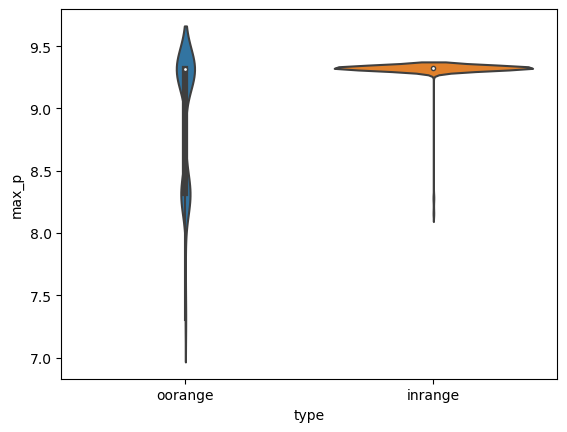

In [66]:
sns.violinplot(x="type", y="max_p", data=comb_Y)

## try using normalized confidences

In [70]:
conf_Y = Y.drop('max_p', axis = 1)

In [71]:
ovo_decision = model21.decision_function(X)

votes = np.round(ovo_decision)
normalized_confidences = ovo_decision - votes

oor_max_normalized_conf = list()
for i in normalized_confidences:
    oor_max_normalized_conf.append(max(i))

conf_Y['max_normalized_conf'] = oor_max_normalized_conf

In [33]:
print(normalized_confidences[0])

[ 0.24758718  0.28989646  0.30460253  0.24945647  0.30833844 -0.31930254
 -0.11294852  0.1891803  -0.3128883   0.21376461]


In [34]:
## for comparison
print(ovo_decision[0])

[ 5.24758718  6.28989646  8.30460253  5.24945647  8.30833844 -0.31930254
  3.88705148  3.1891803   0.6871117   5.21376461]


In [73]:
inrange_ovo_decision = model21.decision_function(inrange_X)

inrange_votes = np.round(inrange_ovo_decision)
inrange_normalized_confidences = inrange_ovo_decision - inrange_votes

inrange_max_normalized_conf = list()
for i in inrange_normalized_confidences:
    inrange_max_normalized_conf.append(max(i))
    
conf_inrange_Y = pd.DataFrame(index=inrange_X.index) 
conf_inrange_Y['max_normalized_conf'] = inrange_max_normalized_conf

In [74]:
print(inrange_normalized_confidences[0])

[-0.31258801 -0.25516901 -0.29884067  0.3249307  -0.22179118 -0.31521643
  0.32655816 -0.22818103 -0.31778093 -0.31568045]


In [75]:
print(inrange_ovo_decision[0])

[2.68741199 5.74483099 4.70115933 8.3249307  3.77820882 0.68478357
 9.32655816 6.77181897 0.68221907 0.68431955]


In [76]:
conf_oorange_Y = conf_Y.drop('ribotype', axis = 1)
conf_oorange_Y['type'] = 'oorange'
conf_inrange_Y['type'] = 'inrange'
conf_combined_Y = pd.concat([conf_oorange_Y, conf_inrange_Y])

In [77]:
conf_combined_Y

,max_normalized_conf,type
SRR3629440,0.308338,oorange
SRR6009475,0.318731,oorange
SRR3338621,0.320389,oorange
SRR6009709,0.321113,oorange
SRR3335252,0.320845,oorange
...,...,...
SRR3357915,0.327464,inrange
SRR6009429,0.326483,inrange
ERR126241,0.327368,inrange
SRR7309242,0.325381,inrange


In [78]:
conf_combined_Y.to_csv('/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/max_normalized_confidence_inandoutrange.csv', index = True, header = True)

<Axes: xlabel='type', ylabel='max_normalized_conf'>

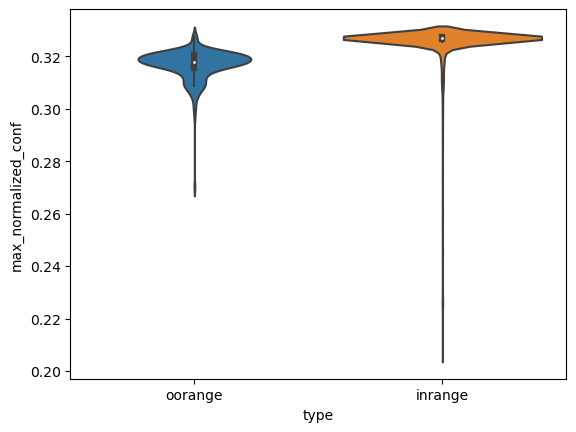

In [79]:
sns.violinplot(x="type", y="max_normalized_conf", data=conf_combined_Y)

## try with averaged prob??

In [84]:
avg_Y = Y.drop('max_p', axis = 1)

In [85]:
oor_ovo_decision = model21.decision_function(X)

oor_avg_p = list()
for i in oor_ovo_decision:
    oor_avg_p.append(np.mean(i))
    
avg_Y['avg_p'] = oor_avg_p

In [86]:
inrange_ovo_decision = model21.decision_function(inrange_X)

inrange_avg_p = list()
for i in inrange_ovo_decision:
    inrange_avg_p.append(np.mean(i))
    
avg_inrange_Y = pd.DataFrame(index=inrange_X.index) 
avg_inrange_Y['avg_p'] = inrange_avg_p

In [87]:
avg_oorange_Y = avg_Y.drop('ribotype', axis = 1)
avg_oorange_Y['type'] = 'oorange'
avg_oorange_Y

,avg_p,type
SRR3629440,4.605769,oorange
SRR6009475,4.501702,oorange
SRR3338621,4.458956,oorange
SRR6009709,4.507210,oorange
SRR3335252,4.544974,oorange
...,...,...
SRR3629647,4.525549,oorange
ERR3473796,4.522278,oorange
SRR3629682,4.505600,oorange
ERR3465387,4.486260,oorange


In [88]:
avg_inrange_Y['type'] = 'inrange'
avg_inrange_Y

,avg_p,type
ERR2232524,4.338624,inrange
SRR3358263,4.542886,inrange
SRR3355860,4.443603,inrange
ERR031697,4.489660,inrange
SRR7309037,4.497305,inrange
...,...,...
SRR3357915,4.543468,inrange
SRR6009429,4.410347,inrange
ERR126241,4.502207,inrange
SRR7309242,4.510141,inrange


In [89]:
avg_comb_Y = pd.concat([avg_oorange_Y, avg_inrange_Y])
avg_comb_Y

,avg_p,type
SRR3629440,4.605769,oorange
SRR6009475,4.501702,oorange
SRR3338621,4.458956,oorange
SRR6009709,4.507210,oorange
SRR3335252,4.544974,oorange
...,...,...
SRR3357915,4.543468,inrange
SRR6009429,4.410347,inrange
ERR126241,4.502207,inrange
SRR7309242,4.510141,inrange


In [90]:
avg_comb_Y.to_csv('/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/avg_decision_function_inandoutrange.csv', index = True, header = True)

<Axes: xlabel='type', ylabel='avg_p'>

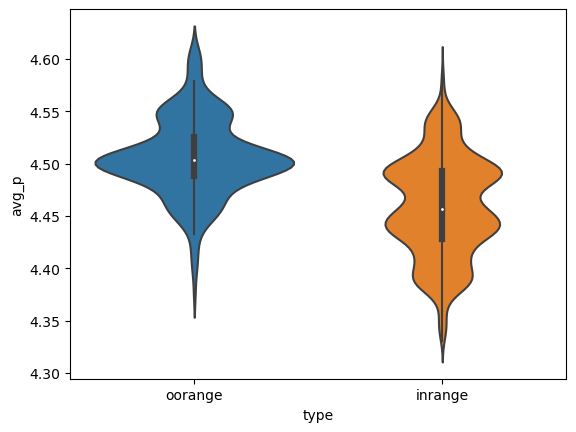

In [91]:
sns.violinplot(x="type", y="avg_p", data=avg_comb_Y)

## try comparing number of k-mers present in out of range and in range genome sequences

In [11]:
oor_kmer_df = pd.DataFrame(X.sum(axis=1), columns = ['total_kmer_count'])
oor_kmer_df

,total_kmer_count
SRR3629440,4418
SRR6009475,3781
SRR3338621,3714
SRR6009709,3787
SRR3335252,3709
...,...
SRR3629647,3930
ERR3473796,3657
SRR3629682,3763
ERR3465387,3638


In [14]:
inrange_kmer_df = pd.DataFrame(inrange_X.sum(axis=1), columns = ['total_kmer_count'])
inrange_kmer_df

,total_kmer_count
ERR2232524,3664
SRR3358263,3776
SRR3355860,3691
ERR031697,3657
SRR7309037,5011
...,...
SRR3357915,3835
SRR6009429,3656
ERR126241,3788
SRR7309242,4771


<Axes: xlabel='type', ylabel='total_kmer_count'>

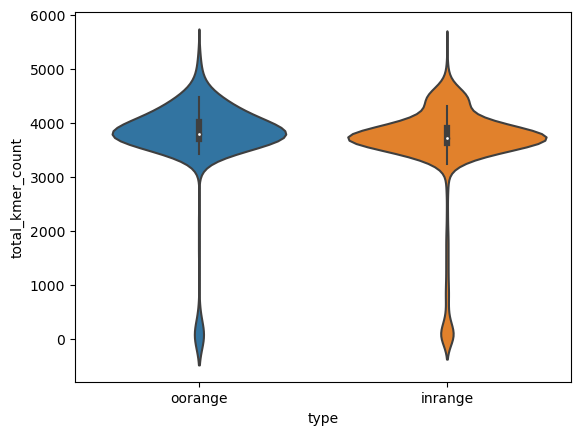

In [15]:
inrange_kmer_df['type'] = 'inrange'
oor_kmer_df['type'] = 'oorange'
comb_kmer_df = pd.concat([oor_kmer_df, inrange_kmer_df])

sns.violinplot(x="type", y="total_kmer_count", data=comb_kmer_df)

In [80]:
comb_kmer_df

,total_kmer_count,type
SRR3629440,4418,oorange
SRR6009475,3781,oorange
SRR3338621,3714,oorange
SRR6009709,3787,oorange
SRR3335252,3709,oorange
...,...,...
SRR3357915,3835,inrange
SRR6009429,3656,inrange
ERR126241,3788,inrange
SRR7309242,4771,inrange


In [81]:
comb_kmer_df.to_csv('/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/sum_kmers_inandoutrange.csv', index = True, header = True)